Nama : Yolanda Ester Berliana Ritonga

Email : yolandaesterbrtg@gmail.com

Proyek Akhir : Image Classification Model Deployment

In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf

**Download Dataset**

In [5]:
od.download('https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yolandaesterbritonga
Your Kaggle Key: ··········


100%|██████████| 219M/219M [00:04<00:00, 49.7MB/s]


In [6]:
dataset_path = '/content/rice-image-dataset/Rice_Image_Dataset'

**Menghapus kelas .ipynb_checkpoints**

In [36]:
if '.ipynb_checkpoints' in os.listdir(dataset_path):
    os.rmdir(os.path.join(dataset_path, '.ipynb_checkpoints'))

In [35]:
class_counts = {}
total_samples = 0

In [37]:
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_samples = len(os.listdir(class_path))
        class_counts[class_name] = num_samples

In [38]:
for class_name, count in class_counts.items():
    print(f"Kelas: {class_name}, Jumlah Sampel: {count}")

Kelas: Basmati, Jumlah Sampel: 15000
Kelas: Jasmine, Jumlah Sampel: 15000
Kelas: Ipsala, Jumlah Sampel: 15000
Kelas: Arborio, Jumlah Sampel: 15000
Kelas: Karacadag, Jumlah Sampel: 15000


In [39]:
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        num_samples = len(os.listdir(class_path))
        total_samples += num_samples

In [40]:
print(f"Total Keseluruhan Sampel: {total_samples}")

Total Keseluruhan Sampel: 75000


In [41]:
num_classes = len(class_counts)
print(f"Jumlah Kelas: {num_classes}")

Jumlah Kelas: 5


**Membuat direktori baru untuk train dan test**

In [14]:
train_dir = '/content/rice-image-dataset/train'
test_dir = '/content/rice-image-dataset/test'

**Membagi dataset menjadi train dan test**

In [15]:
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        image_list = os.listdir(class_path)
        train_images, test_images = train_test_split(image_list, test_size=0.2, random_state=42)

        # Membuat direktori kelas di train dan test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Menyalin gambar ke direktori train
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

        # Menyalin gambar ke direktori test
        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

**Image Data Augmentation**

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

**Path untuk train dan test**

In [18]:
train_data_path = '/content/rice-image-dataset/train'
test_data_path = '/content/rice-image-dataset/test'

**Data dari Directory**

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 60000 images belonging to 5 classes.


In [20]:
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 15000 images belonging to 5 classes.


**Membangun Model**

In [21]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [22]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

**Compile Model**

In [32]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

**Penggunaan Callbacks**

In [25]:
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

**Melatih Model**

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
1875/1875 [==============================] - ETA: 0s - loss: 0.1607 - accuracy: 0.9525

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 792s 416ms/step - loss: 0.1607 - accuracy: 0.9525 - val_loss: 0.0516 - val_accuracy: 0.9847
Epoch 2/20
1875/1875 [==============================] - 768s 410ms/step - loss: 0.0671 - accuracy: 0.9796 - val_loss: 0.0648 - val_accuracy: 0.9794
Epoch 3/20
1875/1875 [==============================] - 780s 416ms/step - loss: 0.0553 - accuracy: 0.9829 - val_loss: 0.0372 - val_accuracy: 0.9894
Epoch 4/20
1875/1875 [==============================] - 773s 412ms/step - loss: 0.0488 - accuracy: 0.9852 - val_loss: 0.0323 - val_accuracy: 0.9911
Epoch 5/20
1875/1875 [==============================] - 776s 414ms/step - loss: 0.0439 - accuracy: 0.9868 - val_loss: 0.0336 - val_accuracy: 0.9893
Epoch 6/20
1875/1875 [==============================] - 764s 407ms/step - loss: 0.0422 - accuracy: 0.9871 - val_loss: 0.0295 - val_accuracy: 0.9915
Epoch 7/20
1875/1875 [==============================] - 764s 407ms/step - loss: 0.0421 - accuracy: 0.9883 - val_loss: 0.025

**Membuat Akurasi untuk Training dan Validation**

In [27]:
train_accuracy = history.history['accuracy'][-1] * 100
validation_accuracy = history.history['val_accuracy'][-1] * 100

In [28]:
print(f'Akurasi Training: {train_accuracy:.2f}%')
print(f'Akurasi Validation: {validation_accuracy:.2f}%')

Akurasi Training: 99.05%
Akurasi Validation: 99.28%


**Membuat Plot Akurasi**

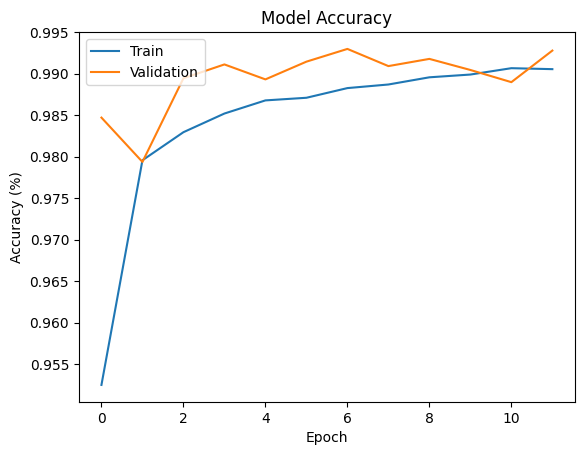

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Membuat Plot Loss**

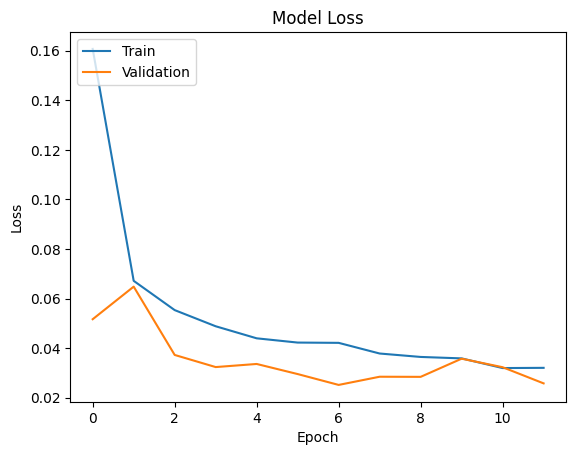

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Menyimpan model ke dalam format TF-Lite**

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [45]:
file_size = os.path.getsize('model.tflite')
print(f"Ukuran File TFLite: {file_size} bytes")

Ukuran File TFLite: 91890640 bytes
